In [126]:
import sys 
sys.path.append('/Users/willknott/Desktop/DIS/coursework/pds/wdk24/src')

%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [127]:
from generation import generate_from_total_pdf
from distributions import total_cdf
from hypothesis_test import signal_background_test

In [128]:
# True parameter values
true_params, alpha, beta = {'f': 0.1, 'lam': 0.5, 'mu': 5.28, 'sigma': 0.018}, 5, 5.6
random_shifts = {
    'f': np.random.uniform(-0.09, 0.5), 
    'lam': np.random.uniform(-0.3, 1), 
    'mu': np.random.uniform(-0.25, 0.3), 
    'sigma': np.random.uniform(-0.01, 0.03)
}
starting_params = {}
for param in true_params:
    starting_params[param] = true_params[param] + random_shifts[param]
    starting_params[param] = float(f'{starting_params[param]:.4}')

In [129]:
n_datapoints = 100
n_init = 100
N = np.logspace(1, 6, num=n_datapoints).astype(int)
N = np.linspace(48000, 65000, n_datapoints).astype(int)
ns = np.array([n_init for _ in range(n_datapoints)])

all_data = [np.array([generate_from_total_pdf(N_events) for _ in range(n_init)]) for N_events in N]


In [130]:
def error_on_p(p, n):
    return np.sqrt((p*(1-p))/n)

### Hypothesis Testing

In [131]:
P = []
P_err = []
validities = []
for i, group_i in enumerate(all_data):
    n_i = ns[i]

    r_discoveries = 0
    for dataset in group_i:

        discovery, _, _ = signal_background_test(dataset=dataset, cdf=total_cdf, starting_params=starting_params)

        if discovery=='h0 invalid' or discovery=='h1 invalid':
            n_i -= 1

        if discovery==True:
            r_discoveries += 1

    p = r_discoveries/n_i
    P.append(p)
    P_err.append(error_on_p(p, n_i))

/Users/willknott/Desktop/DIS/coursework/pds/wdk24/src/distributions.py:115: RuntimeWarning: divide by zero encountered in scalar divide
  background_factor = 1/(expon.cdf(x=beta, scale=1/lam) - expon.cdf(x=alpha, scale=1/lam))
/Users/willknott/Desktop/DIS/coursework/pds/wdk24/src/distributions.py:118: RuntimeWarning: invalid value encountered in multiply
  background_cdf = background_factor*(expon.cdf(x=M, scale=1/lam) - expon.cdf(x=alpha, scale=1/lam))


#---------------
#---------------
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 10.69 (chi2/ndof = 0.0)    │              Nfcn = 378              │
│ EDM = 1.34e+03 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ ABOVE EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│NOT pos. def.│   FORCED   │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────

In [132]:
# successes = []
# for N_i in Ns:
#     n_discoveries = 0
#     for _ in range(n_init):
#         dataset = generate_from_total_pdf(N_i)

#         discovery, _, _ = signal_background_test(dataset=dataset, cdf=total_cdf, starting_params=starting_params)

#         if discovery:
#             n_discoveries += 1
#     successes.append(n_discoveries)

# dict(zip(Ns, successes))

# Finding `N_90`

In [133]:
print(N)
print(P)
print(P_err)
N, P, P_err = np.array(N), np.array(P), np.array(P_err)

[49000 49151 49303 49454 49606 49757 49909 50060 50212 50363 50515 50666
 50818 50969 51121 51272 51424 51575 51727 51878 52030 52181 52333 52484
 52636 52787 52939 53090 53242 53393 53545 53696 53848 54000 54151 54303
 54454 54606 54757 54909 55060 55212 55363 55515 55666 55818 55969 56121
 56272 56424 56575 56727 56878 57030 57181 57333 57484 57636 57787 57939
 58090 58242 58393 58545 58696 58848 59000 59151 59303 59454 59606 59757
 59909 60060 60212 60363 60515 60666 60818 60969 61121 61272 61424 61575
 61727 61878 62030 62181 62333 62484 62636 62787 62939 63090 63242 63393
 63545 63696 63848 64000]
[0.02, 0.030612244897959183, 0.04040404040404041, 0.050505050505050504, 0.050505050505050504, 0.09, 0.11, 0.050505050505050504, 0.09090909090909091, 0.10101010101010101, 0.07, 0.07142857142857142, 0.050505050505050504, 0.05102040816326531, 0.10101010101010101, 0.1326530612244898, 0.07216494845360824, 0.13402061855670103, 0.12244897959183673, 0.09090909090909091, 0.20202020202020202, 0.21

In [143]:
# import pickle 

# data_to_save = {
#     'N': N,
#     'P': P,
#     'P_err': P_err
# }

# # Save the data to a pickle file
# with open('PN_data.pkl', 'wb') as file:
#     pickle.dump(data_to_save, file)

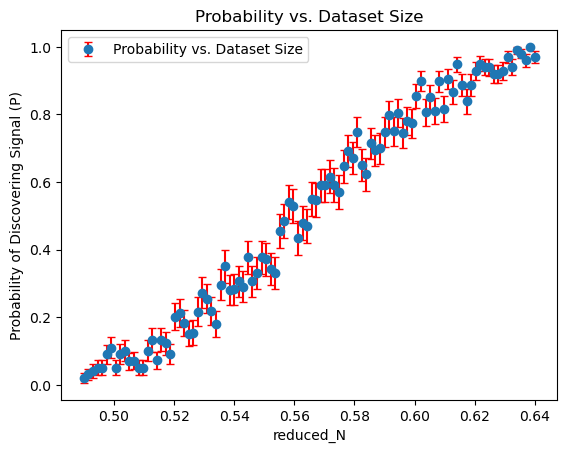

In [135]:
reduced_N = N*1e-5

fig, ax = plt.subplots()
ax.errorbar(reduced_N, P, yerr=P_err, fmt='o', ecolor='red', capsize=3, label='Probability vs. Dataset Size')
ax.set_xlabel('reduced_N')
ax.set_ylabel('Probability of Discovering Signal (P)')
ax.set_title('Probability vs. Dataset Size')
ax.legend()

/var/folders/v_/fs61ry8x6h9dg62cykggbxh00000gn/T/ipykernel_69029/1346206020.py:11: RuntimeWarning: divide by zero encountered in divide
  return np.sum(((P - linear_model(N, m, b)) / P_err) ** 2)


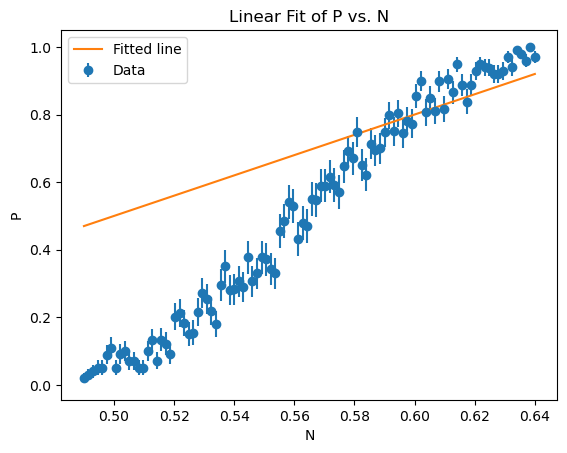

(3.0, -1.0, nan, nan)

In [146]:
from iminuit import Minuit

N = reduced_N

# Define the linear model
def linear_model(N, m, b):
    return m * N + b

# Define the chi-squared function
def chi2_linear(m, b):
    return np.sum(((P - linear_model(N, m, b)) / P_err) ** 2)

# Perform the minimization
mi = Minuit(chi2_linear, m=3, b=-1)
mi.limits['b'] = (-3, 1)
mi.limits['m'] = (1, 20)
mi.errordef = Minuit.LEAST_SQUARES
mi.migrad()  # finds minimum of chi-square function

# Get parameters and errors
m_fit = mi.values['m']
b_fit = mi.values['b']
m_err = mi.errors['m']
b_err = mi.errors['b']

# Plotting
plt.errorbar(N, P, yerr=P_err, fmt='o', label='Data')
plt.plot(N, linear_model(N, *mi.values), label='Fitted line')
plt.xlabel('N')
plt.ylabel('P')
plt.legend()
plt.title('Linear Fit of P vs. N')
plt.show()

(m_fit, b_fit, m_err, b_err)
